In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_speaker_listener_v4, simple_push_v3

# def make_env():
#     env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
#     env.reset()
#     return env

# def make_env_human():
#     env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
#     env.reset()
#     return env

def make_env():
    env = simple_push_v3.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_push_v3.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

# Test the environment
env = make_env()
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['adversary_0', 'agent_0']


# Hyperparameters

Simple push

This environment has 1 good agent, 1 adversary, and 1 landmark. The good agent is rewarded based on the distance to the landmark. The adversary is rewarded if it is close to the landmark, and if the agent is far from the landmark (the difference of the distances). Thus the adversary must learn to push the good agent away from the landmark.

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

num_expert_episodes = 50
# Agent dimensions
adversary_obs_dim = 8
agent_obs_dim = 19 

adversary_act_dim = 5 
agent_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

# Two layers network, applied for discriminator, policy and value network
all_hid_dim = 64

all_agents = env.agents

obs_dims = {
    "adversary_0": adversary_obs_dim,
    "agent_0": agent_obs_dim
}

act_dims = {
    "adversary_0": adversary_act_dim,
    "agent_0": agent_act_dim
}

hid_dims = {
    "adversary_0": all_hid_dim,
    "agent_0": all_hid_dim
}

# Evaluated from 5000 expert episodes
expert_mean_reward = -12

EXPERT_AGENT_REWARDS = {'adversary_0': np.float64(-3.15), 'agent_0': np.float64(-7.34)}


Simple listener speaker

In [3]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

# num_expert_episodes = 50
# # Agent dimensions
# speaker_obs_dim = 3     #[goal_id]
# listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

# speaker_act_dim = 3 
# listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

# # Two layers network, applied for discriminator, policy and value network
# all_hid_dim = 64

# all_agents = env.agents

# obs_dims = {
#     "speaker_0": speaker_obs_dim,
#     "listener_0": listener_obs_dim
# }

# act_dims = {
#     "speaker_0": speaker_act_dim,
#     "listener_0": listener_act_dim
# }

# hid_dims = {
#     "speaker_0": all_hid_dim,
#     "listener_0": all_hid_dim
# }

# # Evaluated from 5000 expert episodes
# expert_mean_reward = -39.53

In [2]:
import pickle


with open("Expert_data/expert_data_rllib_simple_push_200.pickle", "rb") as f:
    expert_data = pickle.load(f)

# Expert Demonstrations
Load the expert policy from paper Inverse Factorized Soft Q-Learning for Cooperative Multi-agent Imitation Learning


In [5]:
env = make_env()

In [6]:
# import torch

# # Load the expert policy
# expert_policies = torch.jit.load("Expert_data/simple_speaker_listener.pt").to(device)
# expert_policies.eval()

# # Try to retrieve h_dim from the policy, fallback to 128
# try:
#     h_dim = expert_policies.h_dim
#     print(f"Retrieved h_dim: {h_dim}")
# except AttributeError:
#     h_dim = 128  # From error message
#     print("h_dim not accessible, using 128")

# def expert_policy(obs, rnn_actor, deterministic=True):
#     with torch.no_grad():
#         # Convert observations to tensors
#         obs_speaker = torch.FloatTensor(obs["speaker_0"]).to(device)
#         obs_listener = torch.FloatTensor(obs["listener_0"]).to(device)
#         # Pad speaker's observation (3) to match listener’s (11)
#         obs_speaker_padded = torch.nn.functional.pad(obs_speaker, (0, 11 - 3))
#         obs_batch = torch.stack([obs_speaker_padded, obs_listener], dim=0)
        
#         # Define masks and available actions
#         masks = torch.ones((2, 1), dtype=torch.bool, device=device)  # For 2 agents
#         avails = torch.ones((2, 5), dtype=torch.float32, device=device)  # Assuming 5 actions per agent
        
#         # Forward pass through the policy
#         actions, _, new_rnn_actor = expert_policies._forward(
#             obs_batch, rnn_actor, masks, avails, deterministic
#         )
#         actions_dict = {
#             "speaker_0": actions[0].item(),
#             "listener_0": actions[1].item()
#         }
#         return actions_dict, new_rnn_actor

# def generate_expert_data(num_episodes=50):
#     env = make_env()

#     # TODO should change the data structure to actually store tuple (s,a)
#     expert_data = {agent: {"states": [], "actions": []} for agent in env.agents}

#     for _ in range(num_episodes):
#         obs, _ = env.reset()
#         # Initialize rnn_actor with shape (n_agents, 1, h_dim) on device
#         rnn_actor = torch.zeros((2, 1, h_dim), device=device)

#         while env.agents:
#             actions, rnn_actor = expert_policy(obs, rnn_actor, deterministic=True)
#             for agent in env.agents:
#                 expert_data[agent]["states"].append(obs[agent])
#                 expert_data[agent]["actions"].append(actions[agent])
#             obs, rewards, terminations, truncations, infos = env.step(actions)

#     env.close()
#     return expert_data


In [7]:
# Generate data
# expert_data = generate_expert_data(num_episodes=num_expert_episodes)

In [8]:
agent = env.agents[0]
expert_states = torch.FloatTensor(expert_data[agent]["states"]).to(device)
expert_actions = torch.LongTensor(expert_data[agent]["actions"]).to(device)

C:\Users\wangy\AppData\Local\Temp\ipykernel_52252\3366628753.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  expert_states = torch.FloatTensor(expert_data[agent]["states"]).to(device)


In [9]:
expert_states.shape

torch.Size([7200, 8])

In [10]:
expert_actions.shape

torch.Size([7200])

### Evaluate the Expert Policy

In [11]:
import torch
import numpy as np

def evaluate_policy_for_expert(policy_func, num_episodes=50, threshold=0.1, h_dim=128, device=device):
    env = make_env()
    avg_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = policy_func(obs, rnn_actor, deterministic=True)
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())

        avg_rewards.append(total_reward)

    env.close()
    return {
        "avg_reward": np.mean(avg_rewards),
    }


In [12]:
# Evaluate the expert policy
# expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
# print("Expert Policy Evaluation:", expert_eval)


# Policy Evaluation Function

In [13]:
def learned_policy(policies, obs, device=device):
    """
    Retrieves actions from the learned policy networks for both agents based on observations.

    Args:
        policies (dict): Dictionary mapping agent names to their Policy network instances.
        obs (dict): Dictionary of observations for each agent.
        device (str): Device to perform computations on ("cuda:0" or "cpu").

    Returns:
        dict: Dictionary mapping agent names to selected actions.
    """
    actions = {}
    for agent in obs:
        policy = policies[agent]
        # Convert observation to tensor and move to device
        obs_tensor = torch.FloatTensor(obs[agent]).to(device)
        with torch.no_grad():
            # Get action probabilities from the policy network
            action_probs = policy(obs_tensor)
            # Select the action with the highest probability
            action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

def evaluate_policy_for_training(policies, num_episodes=50, threshold=0.1, device=device):
    """
    Evaluates the performance of learned policies over multiple episodes.

    Args:
        policies (dict): Dictionary of Policy networks for each agent.
        num_episodes (int): Number of episodes to run for evaluation (default: 50).
        threshold (float): Distance threshold to determine success (default: 0.1).
        device (str): Device to perform computations on (default: "cuda:0" or "cpu").

    Returns:
        dict: Dictionary containing evaluation metrics:
              - "success_rate": Mean success rate across episodes.
              - "avg_reward": Mean total reward per episode.
              - "avg_steps": Mean number of steps per episode.
    """
    # Set to evaluation mode to switch off dropout
    for policy in policies.values():
        policy.eval()

    # Initialize the environment
    env = make_env()
    agent_rewards = {agent: [] for agent in env.agents}
    avg_rewards = []

    # Run evaluation over specified number of episodes
    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        episode_agent_rewards = {agent: 0 for agent in env.agents}


        # Run the episode
        while env.agents:
            # Get actions using the learned policy
            actions = learned_policy(policies, obs, device)
            # Step the environment
            obs, rewards, done, _, _ = env.step(actions)
            for agent in env.agents:
                episode_agent_rewards[agent] += rewards[agent]
            total_reward += sum(rewards.values())  # Sum rewards from both agents
        
        for agent in all_agents:
            agent_rewards[agent].append(episode_agent_rewards[agent])
            
        avg_rewards.append(total_reward)

    # Clean up environment resources
    env.close()

    # Compute and return average metrics
    return {
        all_agents[0]: np.mean(agent_rewards[all_agents[0]]),
        all_agents[1]: np.mean(agent_rewards[all_agents[1]]),
        "avg_reward": np.mean(avg_rewards),
    }

# MAGAIL Training

## Define MAGAIL Networks

In [14]:
import torch
import torch.nn as nn

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
# Output the probability of (s,a) Coming from the EXPERT
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize Networks 

policies = {}
discriminators = {}
value_nets = {}

for a in all_agents:
    policies[a] = Policy(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)

    # For Discriminator the output is a single value
    discriminators[a] = Discriminator(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)

    # Initialize value networks to reduce variance (actor critic)
    value_nets[a] = ValueNet(obs_dim=obs_dims[a], hidden_dim=hid_dims[a]).to(device)


## Training MAGAIL Loop

In [15]:
all_expert_rewards = []  # Store all expert rewards
all_episode_rewards = []  # Store all episode rewards
all_agent_rewards = {agent: [] for agent in all_agents}
all_expert_agent_rewards = {agent: [] for agent in all_agents}

def train_magail(expert_data, num_epochs=1000, batch_size=32):
    
    optimizers = {
        agent: {
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=1e-3),
            "disc": torch.optim.Adam(discriminators[agent].parameters(), lr=1e-3),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=1e-3)
        } for agent in all_agents
    }

    for epoch in range(num_epochs):
        
        policy_data = collect_policy_trajectories(policies, batch_size=batch_size)

        # --- Update discriminators ---
        for agent in all_agents:
            update_discriminators(agent, expert_data, policy_data, optimizers, batch_size)
        
        # --- Update policies and value (Actor Critic) ---
        for agent in all_agents:
            update_policies(agent, policy_data, optimizers, batch_size)
            
        # Diagnostic
        print_diagnostics(epoch)

    env.close()

def collect_policy_trajectories(policies, batch_size=32):
    env = make_env()
    policy_data = {agent: {"states": [], "actions": []} for agent in env.agents}
    obs, _ = env.reset()
    agent = env.agents[0]
    policy_data_length = len(policy_data[agent]["states"])
    while policy_data_length < batch_size:
        while env.agents:
            actions = {}
            for agent in env.agents:
                obs_tensor = torch.FloatTensor(obs[agent]).to(device)
                action_probs = policies[agent](obs_tensor)
                # Simpling by probability - ensure exploration
                # Similar with Epsilon-Greedy, but used in policy-based algorithms. Epsilon-Greedy is in valued based
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)
            
            obs, rewards, terminations, truncations, infos= env.step(actions)
        env.reset()    
        policy_data_length = len(policy_data[agent]["states"])

    return policy_data

def sample_batch_state_action_pairs(data, agent, batch_size=32):
    '''data: dict: agent -> {"states": [], "actions": []}
    returns: (batch_states, batch_actions) converted to tensor
    '''
    # Sample Expert data
    states = torch.FloatTensor(data[agent]["states"]).to(device)
    actions = torch.LongTensor(data[agent]["actions"]).to(device)

    sample_indices = np.random.choice(len(states), batch_size, replace=False)
    batch_states = states[sample_indices]
    batch_actions = actions[sample_indices]

    return batch_states, batch_actions

def update_discriminators(agent, expert_data, policy_data, optimizers, batch_size):
    # Sample batch from dataset
    expert_states, expert_actions = sample_batch_state_action_pairs(expert_data, agent, batch_size)
    policy_states, policy_actions = sample_batch_state_action_pairs(policy_data, agent, batch_size)
    
    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float().to(device)
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    # Discriminator loss
    # max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))], 
    real_loss = -torch.log(discriminators[agent](expert_states, expert_actions_onehot)).mean()
    fake_loss = -torch.log(1 - discriminators[agent](policy_states, policy_actions_onehot)).mean()
    disc_loss = real_loss + fake_loss
    
    optimizers[agent]["disc"].zero_grad()
    disc_loss.backward()
    optimizers[agent]["disc"].step()

def update_policies(agent, policy_data, optimizers, batch_size):
    policy_states, policy_actions = sample_batch_state_action_pairs(policy_data, agent, batch_size)
    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1 
        # Implicitly, Di - discriminators plays the role of a reward function for the generator, 
        # which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        generator_rewards = torch.log(discriminators[agent](policy_states, policy_actions_onehot))

        # Compute value baseline
        values = value_nets[agent](policy_states)
        # Compute advantages 
        # TD error: (actual reward - estimate(baseline))
        # Then use this advantage as reward/reinforce signal
        advantages = generator_rewards - values.squeeze()

    # Update value network (MSE Loss)
    value_loss = (values.squeeze() - generator_rewards).pow(2).mean()
    # Should always clear the gradient before update
    value_loss.requires_grad = True
    optimizers[agent]["value"].zero_grad()
    value_loss.backward()
    optimizers[agent]["value"].step()

    # Policy gradient
    action_probs = policies[agent](policy_states)

    # Expirement with entropy
    # entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=-1).mean()  # Avoid log(0)

    log_probs = torch.log(action_probs.gather(1, policy_actions.unsqueeze(1)))

    # If we didn't call advantage.detach(), the gradients would flow through the advantage tensor, and the value network's parameters would be updated using the policy loss, which is not what we want.
    # Policy gradient reinforced by advantage
    # TODO we are not using any nature policy gradient TRPO/PPO, but in paper it used
    policy_loss = -(log_probs * advantages.detach()).mean()
    
    optimizers[agent]["policy"].zero_grad()
    policy_loss.backward()
    optimizers[agent]["policy"].step()

def print_diagnostics(epoch):
    if epoch % 50 == 0:
        print("------------------------------------------------------")
        training_eval_stats = evaluate_policy_for_training(policies, num_episodes=20)
        print(f"Epoch {epoch}: {all_agents[0]} Avg Reward={training_eval_stats[all_agents[0]]:.2f}")
        print(f"Epoch {epoch}: {all_agents[1]} Avg Reward={training_eval_stats[all_agents[1]]:.2f}")
        print(f"Epoch {epoch}: Sum Avg Reward={training_eval_stats['avg_reward']:.2f}")
        all_episode_rewards.append(training_eval_stats["avg_reward"])
        for agent in all_agents:
            all_agent_rewards[agent].append(training_eval_stats[agent])
            all_expert_agent_rewards[agent].append(EXPERT_AGENT_REWARDS[agent])

        # expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
        all_expert_rewards.append(expert_mean_reward)
        print(f"Expert Policy: Avg Reward={expert_mean_reward}")

## Training

In [16]:
train_magail(expert_data, num_epochs=2000, batch_size=32)

------------------------------------------------------
Epoch 0: adversary_0 Avg Reward=-29.13
Epoch 0: agent_0 Avg Reward=-24.59
Epoch 0: Sum Avg Reward=-57.77
Expert Policy: Avg Reward=-12
------------------------------------------------------
Epoch 50: adversary_0 Avg Reward=-8.77
Epoch 50: agent_0 Avg Reward=-35.28
Epoch 50: Sum Avg Reward=-47.00
Expert Policy: Avg Reward=-12
------------------------------------------------------
Epoch 100: adversary_0 Avg Reward=-17.57
Epoch 100: agent_0 Avg Reward=-29.93
Epoch 100: Sum Avg Reward=-51.33
Expert Policy: Avg Reward=-12
------------------------------------------------------
Epoch 150: adversary_0 Avg Reward=-36.41
Epoch 150: agent_0 Avg Reward=-22.62
Epoch 150: Sum Avg Reward=-63.72
Expert Policy: Avg Reward=-12
------------------------------------------------------
Epoch 200: adversary_0 Avg Reward=-32.57
Epoch 200: agent_0 Avg Reward=-21.42
Epoch 200: Sum Avg Reward=-58.40
Expert Policy: Avg Reward=-12
------------------------------

# Plotting Training Results

<Figure size 2000x600 with 0 Axes>

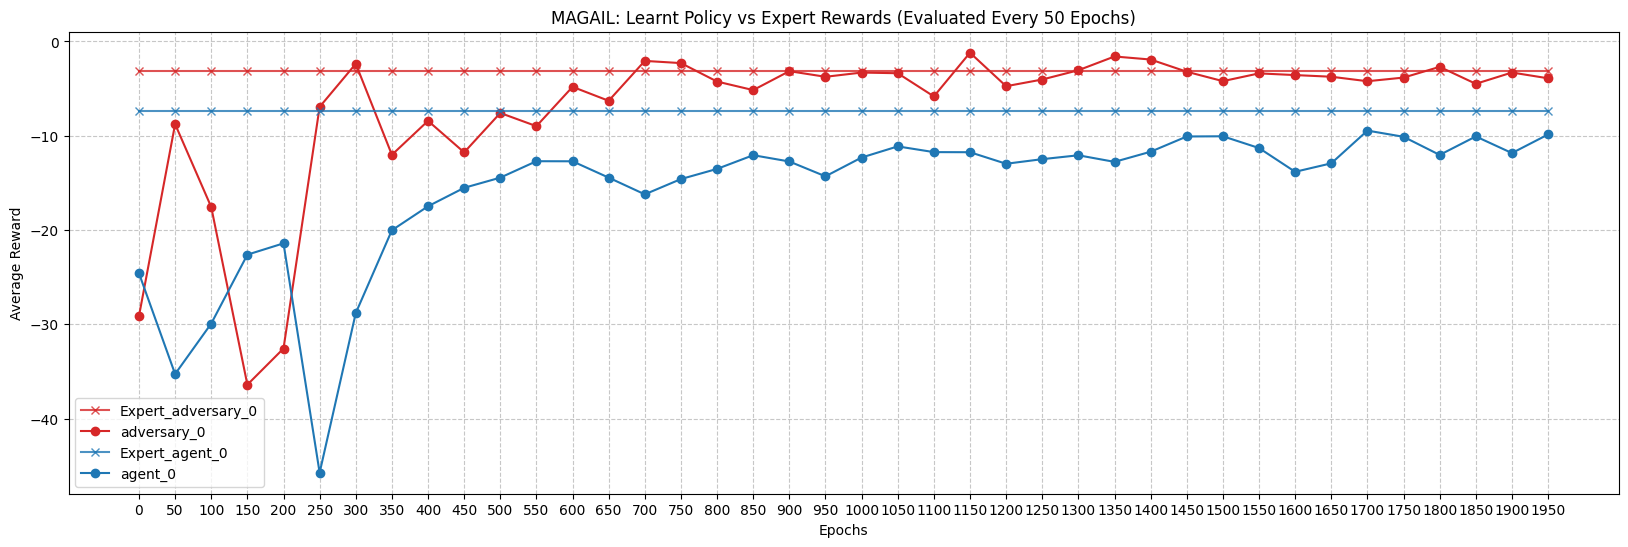

In [17]:
import os
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from datetime import datetime

epochs = range(0, len(all_episode_rewards) * 50, 50)  # X-axis: epochs (0, 50, 100, ...)



# Create the plot
plt.figure(figsize=(20, 6))


# Define distinct colors for each agent (use same color for agent and their expert)
base_colors  = {
    "agent_0": "tab:blue",
    "adversary_0": "tab:red",
    # Add more agents here with distinct colors if needed
}

def faded_color(color_name, alpha=0.3):
    rgb = mcolors.to_rgba(color_name)
    return (*rgb[:3], alpha)  # Return with alpha for transparency


epochs = range(0, len(all_episode_rewards) * 50, 50)  # X-axis: epochs (0, 50, 100, ...)

# Create the plot
plt.figure(figsize=(20, 6))

for agent in all_agents:
    base_color = base_colors.get(agent, 'gray')  

    expert_color = faded_color(base_color, alpha=0.8)
    # Expert rewards with 'x' marker
    plt.plot(
        epochs,
        [EXPERT_AGENT_REWARDS[agent] for _ in all_agent_rewards[agent]],
        label=f"Expert_{agent}",
        marker='x',
        color=expert_color,
        linestyle='-'
    )
    # Learned policy rewards with 'o' marker
    plt.plot(
        epochs,
        all_agent_rewards[agent],
        label=f"{agent}",
        marker='o',
        color=base_color,
        linestyle='-'
    )

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('MAGAIL: Learnt Policy vs Expert Rewards (Evaluated Every 50 Epochs)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)  # Show epoch numbers on x-axis


# Save plot
os.makedirs("plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
save_path = f"plots/magail_{timestamp}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Display the plot
plt.show()

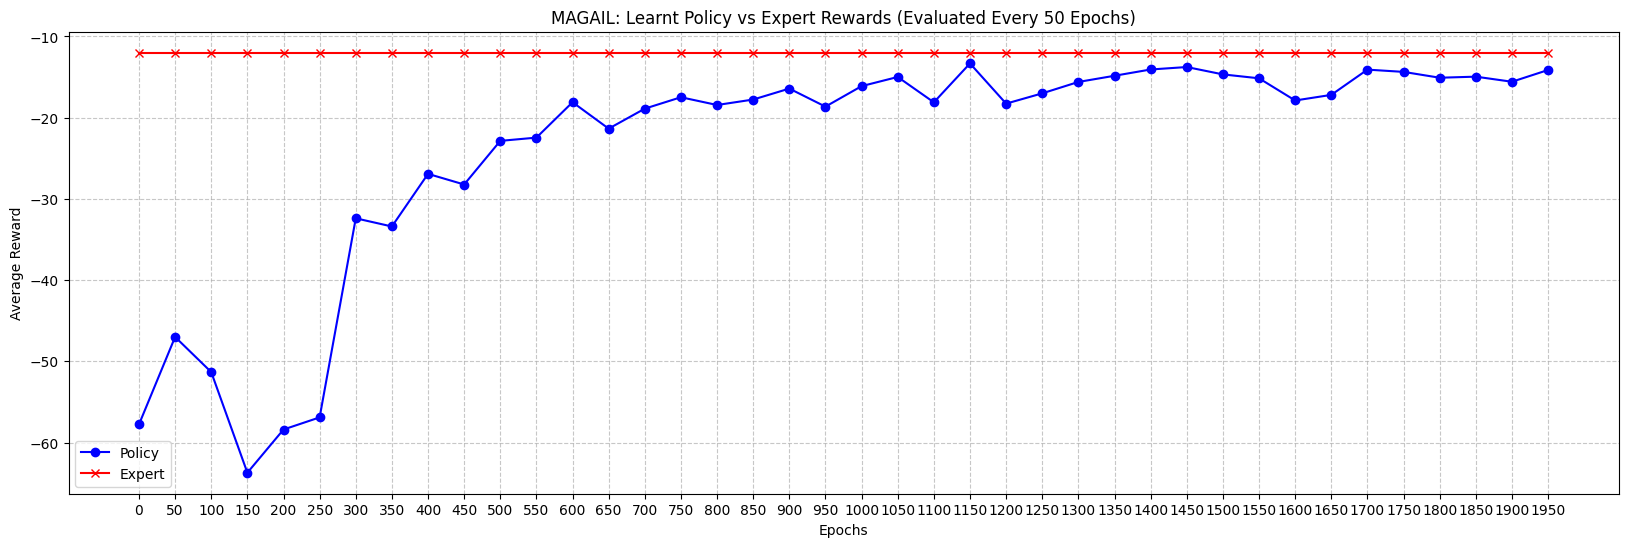

In [18]:
epochs = range(0, len(all_episode_rewards) * 50, 50)  # X-axis: epochs (0, 50, 100, ...)


# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(epochs, all_episode_rewards, label='Policy', marker='o', color='blue')
plt.plot(epochs, all_expert_rewards, label='Expert', marker='x', color='red')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('MAGAIL: Learnt Policy vs Expert Rewards (Evaluated Every 50 Epochs)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)  # Show epoch numbers on x-axis


# Save plot
os.makedirs("plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
save_path = f"plots/magail_{timestamp}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Display the plot
plt.show()